# week 3 
저번주에 잘못한 것 수정하기 + 데이터셋 청원 데이터로 바꾸기

0) 데이터셋 변경 (v)<br>
1) forward, backward 는 k번째 토큰을 k 전의 토큰으로 예측 k 뒤의 토큰으로 예측함 (v)<br>
→ rnn에서 hidden state forward, backward hidden 가져오면 됨. 어차피 time-step으로 예측함<br>
2) padding : 0,  unk : 1 (v)<br>
3) eos, sos는 추가하는게 맞겠다 <br>
lm에서 eos, sos를 추가하는게 맞나? -> 보류 <br>
4) rnn을 for문 돌려서 넣을 필요 없이 바로 넣으면 된다. squeeze같은건 rnn 안에 넣자(src는 어차피 안씀) (v)<br>
5) cnn에서 fc를 빼니 마니? (v)<br>
6) gpu에서 나온 텐서를 쓰려면 스칼라로 만들어줘야함 <br>
epoch_loss += loss.item() : 안하면 epoch_loss에 gpu 할당<br>
7) max_len 긴게 너무 많아서 max 로 안구하고 직접 지정해주는게 나을듯 (v)<br>
8) sent tokenize (v)<br>
9) highway network 추가 (v)

====

# week  4
저번주에 잘못한 것 수정하기<br> 
1) chr에선 cleaning할 필요 없음 <br>
2) max_len이 chr, mecab 달라야함<br>
3) loss에서 `.view`하는 부분 <br>
4) elmo 모델에서 CNN, RNN 불러오는게 더 맞는듯<br>
5) CNN 채널의 output dim이 `sum(filter_size)`이 아니라 `len(filter_size)* N_FILTERS`이 맞음 (맥스풀링 차원이 잘못됨)

# Data Download

In [60]:
device = 'cuda'

In [61]:
with open('../data/petitions_2019-01.txt', 'r') as f:
    corpus = f.readlines()

In [62]:
json_list = [eval(json.strip()) for json in corpus]

In [63]:
corpus = [json['content'] for json in json_list]

In [64]:
import pickle

In [65]:
with open('../data/petitions_dev.p', 'wb') as f:
    pickle.dump(corpus[:1024], f)

In [66]:
with open('../data/petitions.p', 'wb') as f:
    pickle.dump(corpus, f)

# data preprocess

In [67]:
import re
import mecab
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim

import torchtext
import sys
sys.path.append('../source')
from txt_cleaner.clean.master import MasterCleaner
from txt_cleaner.utils import *
from torch8text.data import Vocab, Field

## sent_tokenize

In [68]:
from nltk.tokenize import sent_tokenize
sent_tokenize('안녕하세요? 반갑습니다. 오늘은 엘모를 구현보겠습니다?')

['안녕하세요?', '반갑습니다.', '오늘은 엘모를 구현보겠습니다?']

## field 1: mecab 사용 field

In [69]:
pos = mecab.MeCab()

def tokenize_pos(inp):
    if type(inp) == str:
        return pos.morphs(inp)
    if type(inp) == list:
        return [tokenize_pos(i) for i in inp]

In [70]:
tokenize_pos('안녕하세요'), tokenize_pos(['안녕하세요', '안녕?']), tokenize_pos([['안녕하세요'], ['안녕?']])

(['안녕', '하', '세요'],
 [['안녕', '하', '세요'], ['안녕', '?']],
 [[['안녕', '하', '세요']], [['안녕', '?']]])

### 수인님 cleaner 

In [71]:
config = json_reader('../source/txt_cleaner/cleaner_config.json')

size 1 dictionary is read from ../source/txt_cleaner/cleaner_config.json


In [72]:
config['minimum_space_count'] = 2
config

{'minimum_space_count': 2}

In [73]:
cleaner = MasterCleaner(config)
cleaner.cleaning('안녕하세요? 반갑습니다! 행복하세요~**')

'안녕하세요? 반갑습니다! 행복하세요'

In [74]:
tokenize_pos(['안녕하세요', '안녕'])

[['안녕', '하', '세요'], ['안녕']]

In [75]:
def flatten(S):
    if S == []:
        return S
    if isinstance(S[0], list):
        return flatten(S[0]) + flatten(S[1:])
    return S[:1] + flatten(S[1:])

In [76]:
token_max_len = 40

In [77]:
mecab_field = Field(tokenize = tokenize_pos, 
                    preprocessing = lambda e: cleaner.cleaning(e),
                    init_token = False,
                    eos_token = False,
                    max_len = token_max_len
                )

In [78]:
flatten([[['dks','df']]])

['dks', 'df']

In [79]:
train = [sen
         for text in corpus 
         for sen in sent_tokenize(text)
         if cleaner.cleaning(sen)]
train[:5]

['국민과 소통하시고 자유롭고 행복한 나라를 만들기 위해 힘쓰고 계신 대통령께 존경과 찬사를 올립니다.',
 '기해년 새해 복 많이 받으십시오.',
 '저는 경북 울진군 북면 부구검성로 12번지에 살고 있는 북면발전협의회장 이희국이라고 합니다.',
 '저는 8기의 원전이 가동․건설되고 있는 이곳 북면에 태어나 68년째 거주하고 있는 원전지역 주민입니다.',
 '간절한 마음을 담아 대통령께 다음과 같이 호소 드립니다.']

In [80]:
mecab_field.build_vocab(train)
mecab_field.preprocess('안녕하세요? 룰루랄라 ㅇㅇㄹ')

['안녕', '하', '세요', '?', '룰루랄라']

In [103]:
train[:3]

['국민과 소통하시고 자유롭고 행복한 나라를 만들기 위해 힘쓰고 계신 대통령께 존경과 찬사를 올립니다.',
 '기해년 새해 복 많이 받으십시오.',
 '저는 경북 울진군 북면 부구검성로 12번지에 살고 있는 북면발전협의회장 이희국이라고 합니다.']

## field 2:  chr-level field

In [104]:
chr_field = Field(tokenize = list, 
                  init_token = False,
                  eos_token = False,
                )

In [105]:
chr_field.build_vocab(train)

In [106]:
token_chr = chr_field.preprocess('안녕하세요sd')
chr_field.process(token_chr)

[75, 546, 10, 64, 50, 355, 421]

# dataset, dataloader

In [107]:
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
from dataset import *

In [108]:
chr_max_len = 3

In [109]:
ds = ELMoDataset(train, mecab_field, chr_field, token_max_len = token_max_len, chr_max_len = chr_max_len)

In [110]:
X  = [torch.tensor([[72,  0,  0,  0,  0]]), torch.tensor([[0, 0, 0, 0, 0]])]

In [111]:
torch.cat(X)

tensor([[72,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0]])

In [112]:
chr_field.preprocess(['ek', 'edd'])

[['e', 'k'], ['e', 'd', 'd']]

In [113]:
data = '안녕하세요 반갑습니ek edd'
token_data = mecab_field.preprocess(data)
print(token_data)
token_chr_data = chr_field.preprocess(token_data) #cleaning이 영어만 있으면 지워버림
print(token_chr_data)
process_chr = chr_field.pad_process(token_chr_data, max_len = chr_max_len)
print(process_chr)

['안녕', '하', '세요', '반갑', '습니', 'ek', 'edd']
[['안', '녕'], ['하'], ['세', '요'], ['반', '갑'], ['습', '니'], ['e', 'k'], ['e', 'd', 'd']]
tensor([[ 75, 546,   0],
        [ 10,   0,   0],
        [ 64,  50,   0],
        [173, 419,   0],
        [ 49,  11,   0],
        [295, 500,   0],
        [295, 421, 421]])


In [114]:
process_chr.shape

torch.Size([7, 3])

In [115]:
ds[1]

data(src_chr=tensor([[  1,   0,   0],
        [ 94,   0,   0],
        [  1,   0,   0],
        [203,   0,   0],
        [  1,   0,   0],
        [128,   0,   0],
        [  1,   0,   0],
        [  7,   0,   0]]), trg=tensor([  47, 1860, 1948,  176,   48, 7827,    4]))

In [116]:
for _ in ds:
    print(_.src_chr)
    print(_.trg)
    break

tensor([[  1,   0,   0],
        [ 66,   0,   0],
        [  1,   0,   0],
        [ 10,   0,   0],
        [ 29,   0,   0],
        [  9,   0,   0],
        [  1,   0,   0],
        [562,   0,   0],
        [  9,   0,   0],
        [  1,   0,   0],
        [ 18,   0,   0],
        [  1,   0,   0],
        [ 30,   0,   0],
        [  1,   0,   0],
        [ 22,   0,   0],
        [  1,   0,   0],
        [  1,   0,   0],
        [  9,   0,   0],
        [  1,   0,   0],
        [  1,   0,   0],
        [351,   0,   0],
        [  1,   0,   0],
        [ 66,   0,   0],
        [  1,   0,   0],
        [ 30,   0,   0],
        [  1,   0,   0],
        [  7,   0,   0]])
tensor([   35,  1711,     7,    52,     9,   368,  1331,     9,   817,    19,
           67,    13,   140,    43,   134,  5522,     9,  2273,    93,   684,
         1468,    35, 15517,    13,  1087,     4])


In [117]:
def pad_collate(batch):
    (src_chr, trg) = zip(*batch)
    named_tuple = namedtuple('data', ['src_chr', 'trg'])
    src_chr_pad = pad_sequence(src_chr, batch_first=True, padding_value=0)
    trg_pad = pad_sequence(trg, batch_first=True, padding_value=0)
    return named_tuple(src_chr_pad, trg_pad)

In [118]:
BATCH_SIZE = 16

In [119]:
dl = DataLoader(ds, batch_size = BATCH_SIZE, collate_fn = pad_collate)
for _ in dl:
    print(_.src_chr.data)
    print(_.src_chr.data.shape)
    print(_.trg.data.shape)
    break

tensor([[[  1,   0,   0],
         [ 66,   0,   0],
         [  1,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],

        [[  1,   0,   0],
         [ 94,   0,   0],
         [  1,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],

        [[ 85,   0,   0],
         [  8,   0,   0],
         [  1,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],

        ...,

        [[  1,   0,   0],
         [  1,   0,   0],
         [ 66,   0,   0],
         ...,
         [ 10,   0,   0],
         [ 13,   0,   0],
         [108,   0,   0]],

        [[  1,   0,   0],
         [  5,   0,   0],
         [  1,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],

        [[  1,   0,   0],
         [  1,   0,   0],
         [  1,   0,   0],
         ...,
         [  0,   0,   0],
        

# CNN + highway

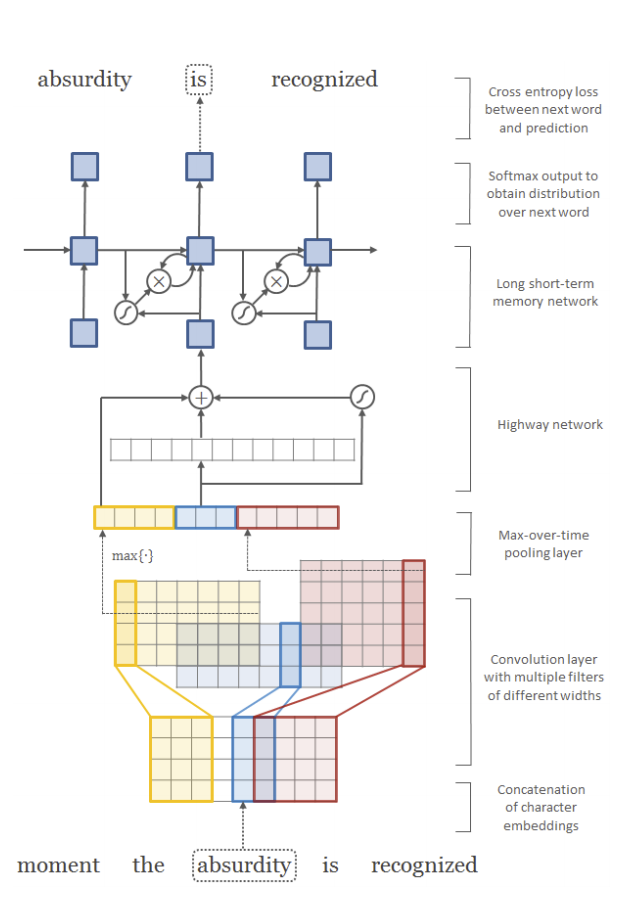

In [120]:
class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, 
                 dropout, pad_idx):
        
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.conv_0 = nn.Conv2d(in_channels = 1, 
                                out_channels = n_filters, 
                                kernel_size = (filter_sizes[0], embedding_dim)) 
        
        self.conv_1 = nn.Conv2d(in_channels = 1, 
                                out_channels = n_filters, 
                                kernel_size = (filter_sizes[1], embedding_dim))
        
        self.conv_2 = nn.Conv2d(in_channels = 1, 
                        out_channels = n_filters, 
                        kernel_size = (filter_sizes[2], embedding_dim))

        
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
                
        #text = [batch size, sent len, token len]
#         print(text.shape) # torch.Size([16, 64, 3])
        bs, max_seq_len, max_chr_len = text.shape
        
        embedded = self.embedding(text.reshape(-1, max_chr_len).unsqueeze(1))
        print(embedded.shape) # batch_size * max_seq_len, 1, max_chr_len, embed_dim
        
        conved_0 = F.relu(self.conv_0(embedded).squeeze(3))
        conved_1 = F.relu(self.conv_1(embedded).squeeze(3))
        conved_2 = F.relu(self.conv_2(embedded).squeeze(3))
        print(conved_0.shape, conved_1.shape, conved_2.shape) 
#           torch.Size([1024, 10, 3]) torch.Size([1024, 10, 2]) torch.Size([1024, 10, 1]) 

        print('conv', conved_0.shape) # [640, 10, 3]
        pooled_0 = torch.max(conved_0, dim = -1).values
        print('pool', pooled_0.shape) # [1024, 3]
        pooled_1 = torch.max(conved_1, dim = -1).values
        pooled_2 = torch.max(conved_2, dim = -1).values
        cat = self.dropout(torch.cat((pooled_0, pooled_1, pooled_2), dim = -1))
        print('cat', cat.shape) # 640, 30
        cat = cat.view(bs, max_seq_len, -1) 
        return cat

In [121]:
VOCAB_SIZE = len(chr_field.vocab)
EMBEDDING_DIM = 1024
N_FILTERS = 10
FILTER_SIZES = (1, 2, 3)
PAD_IDX = chr_field.vocab.stoi_dict['<PAD>']
SPECIAL_TOKENS = chr_field.vocab.special_tokens
SPECIAL_TOKENS_INDEX = chr_field.vocab.special_tokens_idx
OUTPUT_DIM = 512
DROPOUT = 0.5

In [122]:
cnn = CNN(VOCAB_SIZE, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)

In [123]:
_.src_chr.data.shape # batch_size, max_seq_len(문장 내 토큰 개수), max_chr_len(토큰 내 chr개수)

torch.Size([16, 40, 3])

In [124]:
cnn_output = cnn(_.src_chr.data) # batch_size(=16) * max_seq_len(=40), 1(channel 개수), max_chr_len 
cnn_output.shape # 3 (from conv 1) + 2 (from conv 2) + 1 (from conv 3)

torch.Size([640, 1, 3, 1024])
torch.Size([640, 10, 3]) torch.Size([640, 10, 2]) torch.Size([640, 10, 1])
conv torch.Size([640, 10, 3])
pool torch.Size([640, 10])
cat torch.Size([640, 30])


torch.Size([16, 40, 30])

In [125]:
_.src_chr

tensor([[[  1,   0,   0],
         [ 66,   0,   0],
         [  1,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],

        [[  1,   0,   0],
         [ 94,   0,   0],
         [  1,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],

        [[ 85,   0,   0],
         [  8,   0,   0],
         [  1,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],

        ...,

        [[  1,   0,   0],
         [  1,   0,   0],
         [ 66,   0,   0],
         ...,
         [ 10,   0,   0],
         [ 13,   0,   0],
         [108,   0,   0]],

        [[  1,   0,   0],
         [  5,   0,   0],
         [  1,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],

        [[  1,   0,   0],
         [  1,   0,   0],
         [  1,   0,   0],
         ...,
         [  0,   0,   0],
        

In [44]:
# https://github.com/kefirski/pytorch_Highway/blob/master/highway/highway.py
class Highway(nn.Module):
    def __init__(self, size, num_layers, f):

        super(Highway, self).__init__()

        self.num_layers = num_layers
        self.nonlinear = nn.ModuleList([nn.Linear(size, size) for _ in range(num_layers)])
        self.linear = nn.ModuleList([nn.Linear(size, size) for _ in range(num_layers)])
        self.gate = nn.ModuleList([nn.Linear(size, size) for _ in range(num_layers)])
        self.f = f

    def forward(self, x):
        """
            :param x: tensor with shape of [batch_size, size]
            :return: tensor with shape of [batch_size, size]
            applies σ(x) ⨀ (f(G(x))) + (1 - σ(x)) ⨀ (Q(x)) transformation | G and Q is affine transformation,
            f is non-linear transformation, σ(x) is affine transformation with sigmoid non-linearition
            and ⨀ is element-wise multiplication
            """

        for layer in range(self.num_layers):
            gate = torch.sigmoid(self.gate[layer](x))

            nonlinear = self.f(self.nonlinear[layer](x))
            linear = self.linear[layer](x)

            x = gate * nonlinear + (1 - gate) * linear

        return x

In [45]:
HIGHWAY_N_LAYERS = 1

In [47]:
highway = Highway(30, HIGHWAY_N_LAYERS, f=torch.nn.functional.relu)
highwayed_output = highway(cnn_output)
print(highwayed_output.shape)

torch.Size([16, 40, 30])


In [48]:
# https://github.com/GyuminJack/torchstudy/blob/main/05May/ELMo/src/models.py
class LSTM_LM(nn.Module):
    def __init__(self, input_dim, output_dim, hid_dim, n_layers, dropout, bidirectional):
        super().__init__()
        
        self.output_dim = output_dim
        self.input_dim = input_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.lstm = nn.LSTM(input_dim, hid_dim, n_layers, dropout = dropout, bidirectional = bidirectional)
        self.fc_out = nn.Linear(hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, input):
        # batch_size, seq_len, 30 -> seq_len, batch_size, 30
        input = input.permute(1, 0, 2)
        output, (hidden, cell) = self.lstm(input)  
        seq_len, bs, _ = output.size()
        # output : (seq_len, batch, num_directions * hidden size) -> (seq_len, batch, hidden_size, num_directions)
        output = output.reshape(seq_len, bs, -1, 2) # 2 because bidirectional, stacked RNN output is last layer output
        forward_hidden, backward_hidden = output[:,:,:,0], output[:,:,:,1]
        # forward_hidden : (seq_len, batch, hidden_size)
        # forward_prediction : (seq_len, batch, output_dim) -> (batch, seq_len, output_dim)
        forward_prediction = self.fc_out(forward_hidden).permute(1, 0, 2)
        backward_prediction = self.fc_out(backward_hidden).permute(1, 0, 2)
        return forward_prediction, backward_prediction

In [50]:
INPUT_DIM = OUTPUT_DIM
PREDICT_DIM = len(mecab_field.vocab)
HID_DIM = 1024
N_LAYERS = 2
DROPOUT = 0.5
BIDIRECTIONAL = True
TRG_PAD_IDX = mecab_field.vocab.stoi_dict['<PAD>']

In [52]:
rnn = LSTM_LM(30, PREDICT_DIM, HID_DIM, N_LAYERS, DROPOUT, BIDIRECTIONAL)

In [53]:
INPUT_DIM

512

In [56]:
highwayed_output.shape

torch.Size([16, 40, 30])

In [54]:
forward_prediction, backward_prediction = rnn(highwayed_output)
forward_prediction.shape

torch.Size([16, 40, 50887])

In [128]:
forward_prediction.shape

torch.Size([16, 40, 50887])

In [129]:
torch.max(forward_prediction, dim=2).indices

tensor([[22647, 22647, 22647, 12084, 12084, 12084, 31934, 22647, 48372, 30474,
         12084, 12084,  5053,  5053, 22647, 12084, 22647, 30474, 31934,  5053,
         31934, 42027, 22647, 31934,  5053, 31934, 22647, 31934, 31934, 48372,
         22647, 31934, 31934, 48372, 31934, 31934, 48372, 48372, 12084, 31934],
        [22647, 12084, 48372, 48372, 30474, 31934, 30474, 30474, 36191, 31934,
         31934, 48372, 12084, 22647, 48372, 22647, 22647, 22647, 31934, 22647,
         12084, 22647, 22647, 31934, 31934, 22647, 22647, 31934, 48372, 22647,
         48372, 31934, 31934, 31934, 31934, 12084, 31934, 31934, 31934, 31934],
        [12084, 12084, 12084, 48372, 31934, 31934, 12084, 22647, 22647, 31934,
         31934, 31934, 48372, 48372, 48372, 48372, 50343, 48372,  5053,  5053,
         31934, 31934, 22647, 12084, 12084, 22647, 31934, 36191, 31934, 31934,
         22647, 22647, 22647, 31934, 31934, 12084, 12084, 12084, 31934, 28340],
        [22647, 22647, 12084, 12084, 48372, 39887

In [130]:
class ELMo(nn.Module):
    def __init__(self, cnn, highway, rnn):
        super().__init__()
        self.cnn = cnn
        self.highway = highway
        self.rnn = rnn
        
    def forward(self, input):
        output = self.cnn(input)
        output = self.highway(output)
        forward_output, backward_output = self.rnn(output)
        return forward_output, backward_output

In [131]:
elmo = ELMo(cnn, highway, rnn)
elmo.to(device);

In [132]:
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

optimizer = optim.Adam(elmo.parameters(), lr=0.000005)
scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

In [133]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [134]:
elmo.apply(initialize_weights);

In [131]:
N_EPOCHS = 20

In [137]:
for src_chr, trg in dl:
    break

In [141]:
elmo(src_chr.to('cuda'))

torch.Size([640, 1, 3, 1024])
torch.Size([640, 10, 3]) torch.Size([640, 10, 2]) torch.Size([640, 10, 1])
conv torch.Size([640, 10, 3])
pool torch.Size([640, 10])
cat torch.Size([640, 30])


(tensor([[[ 1.7630e-02,  1.6244e-02,  2.1732e-02,  ...,  2.3951e-02,
           -2.2879e-02,  1.3721e-03],
          [ 1.7910e-02,  1.6450e-02,  2.1410e-02,  ...,  2.3157e-02,
           -2.3191e-02,  5.6256e-04],
          [ 1.7468e-02,  1.7048e-02,  2.0837e-02,  ...,  2.3615e-02,
           -2.3864e-02,  1.5615e-03],
          ...,
          [ 1.5385e-02,  1.6670e-02,  2.0046e-02,  ...,  2.1859e-02,
           -2.2213e-02,  6.6230e-04],
          [ 1.4940e-02,  1.5532e-02,  2.0775e-02,  ...,  2.2977e-02,
           -2.3200e-02,  2.1373e-03],
          [ 1.4570e-02,  1.5425e-02,  2.0309e-02,  ...,  2.2397e-02,
           -2.3648e-02,  1.7292e-03]],
 
         [[ 1.6693e-02,  1.6161e-02,  2.2262e-02,  ...,  2.3181e-02,
           -2.4347e-02,  5.5814e-04],
          [ 1.7679e-02,  1.5856e-02,  2.1332e-02,  ...,  2.3081e-02,
           -2.3435e-02, -5.1210e-04],
          [ 1.7050e-02,  1.4442e-02,  2.0571e-02,  ...,  2.4900e-02,
           -2.2792e-02, -3.5466e-04],
          ...,
    

In [139]:
trg

tensor([[   35,  1711,     7,    52,     9,   368,  1331,     9,   817,    19,
            67,    13,   140,    43,   134,  5522,     9,  2273,    93,   684,
          1468,    35, 15517,    13,  1087,     4,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0],
        [   47,  1860,  1948,   176,    48,  7827,     4,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0],
        [    6,  1930, 13688, 13689,   222, 33433,   130,    27,   265,  3128,
            10,   105,     9,    17,     6, 13689,   495,  1639,  1046, 26650,
             5,    71,    38,     4,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0],
        [    6,   314,    43,    11,  1105,     5,  3172,   596,    26

In [134]:
trg.reshape(-1).shape

torch.Size([624])

In [135]:
log_epoch_loss = []
n_pass = 0
for epoch in range(N_EPOCHS):
    print(f'Epoch {epoch}')
    optimizer.zero_grad()
    i = 0 
    epoch_loss = 0
    for src_chr, trg in dl:
        src_chr, trg = src_chr.to(device), trg.to(device)
        output = cnn(src_chr)
        output = highway(output)
        forward_output, backward_output = rnn(output)
        # forward_output[:, :-1, :] -> (batch, seq_len - 1, output_dim) 
        # forward_output[...].reshape(-1, PREDICT_DIM) -> ((seq_len - 1) * batch, output_dim)
        
        # trg -> (batch_size, seq_len)
        # trg.transpose(1, 0) -> (seq_len, batch_size)
        # trg.view(-1) -> (seq_len * batch_size)
        forward_loss = criterion(forward_output[:, :-1, :].reshape(-1, PREDICT_DIM), trg.transpose(1, 0).reshape(-1))
        backward_loss = criterion(backward_output[:, :-1, :].reshape(-1, PREDICT_DIM), trg.transpose(1, 0).reshape(-1))
        loss = forward_loss + backward_loss
        epoch_loss += loss.item()
        loss.backward()
        print(loss)
        optimizer.step()
        i += 1
    log_epoch_loss += [epoch_loss / i]

Epoch 0
tensor(21.4959, device='cuda:0', grad_fn=<AddBackward0>)
tensor(21.4852, device='cuda:0', grad_fn=<AddBackward0>)
tensor(21.4617, device='cuda:0', grad_fn=<AddBackward0>)
tensor(21.5424, device='cuda:0', grad_fn=<AddBackward0>)
tensor(21.5079, device='cuda:0', grad_fn=<AddBackward0>)
tensor(21.5152, device='cuda:0', grad_fn=<AddBackward0>)
tensor(21.5194, device='cuda:0', grad_fn=<AddBackward0>)
tensor(21.4690, device='cuda:0', grad_fn=<AddBackward0>)
tensor(21.4686, device='cuda:0', grad_fn=<AddBackward0>)
tensor(21.4825, device='cuda:0', grad_fn=<AddBackward0>)
tensor(21.4540, device='cuda:0', grad_fn=<AddBackward0>)
tensor(21.4345, device='cuda:0', grad_fn=<AddBackward0>)
tensor(21.3957, device='cuda:0', grad_fn=<AddBackward0>)
tensor(21.4258, device='cuda:0', grad_fn=<AddBackward0>)
tensor(21.4147, device='cuda:0', grad_fn=<AddBackward0>)
tensor(21.4045, device='cuda:0', grad_fn=<AddBackward0>)
tensor(21.3808, device='cuda:0', grad_fn=<AddBackward0>)
tensor(21.3668, device=

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

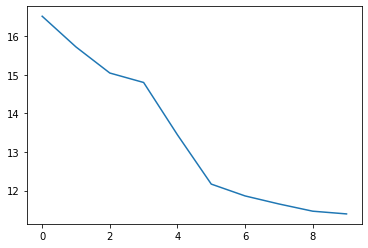

In [63]:
plt.plot(log_epoch_loss)

In [75]:
log_epoch_loss

[16.516703319324336,
 15.721247812771114,
 15.04570914338117,
 14.800581989646728,
 13.444680514748379,
 12.167916640643895,
 11.861345249177592,
 11.653339857584594,
 11.465884133523122,
 11.395304642806664]

# predict

In [76]:
query = '저는 억울합니다'

In [77]:
token_query = mecab_field.preprocess(query)
chr_token_query = chr_field.preprocess(token_query)
processed_query = chr_field.pad_process(chr_token_query, max_len=chr_max_len)

In [78]:
token_query

['저', '는', '억울', '합니다']

In [79]:
processed_query = processed_query.unsqueeze(0)

In [80]:
forward_output, backward_output = elmo(processed_query.to(device))

In [81]:
forward_output.shape

torch.Size([1, 4, 50887])

In [82]:
predicted = torch.argmax(forward_output, dim=2)

In [83]:
predicted

tensor([[103,  73, 726, 726]], device='cuda:0')

In [84]:
predicted = predicted.squeeze(0)

In [86]:
mecab_field.vocab.itos(predicted.tolist())

'전 같 장관 장관'